In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as mae

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale

from IPython.display import clear_output

import structural_model

In [2]:
before = pd.read_csv('./input/prepared_data/test_before_proc.csv')
before = before.rename(columns={'Скважина' : 'well',
                                'Дата' : 'date',
                                'Нефть, т' : 'prod',
                                'Закачка, м3' : 'inj'})
before = before[['well', 'date', 'prod', 'inj', 'X', 'Y', 'group']]

after = pd.read_csv('./input/prepared_data/test_after_proc.csv')
after = after.rename(columns={'Скважина' : 'well',
                                'Дата' : 'date',
                                'Закачка, м3' : 'inj'})
after = after[['well', 'date', 'inj', 'group']]

In [3]:
coords = before.groupby('well')[['X', 'Y']].mean()
prod = before[['well', 'date', 'prod']].set_index(['well', 'date']).unstack(0)
prod.columns = prod.columns.droplevel()
inj = before[['well', 'date', 'inj']].set_index(['well', 'date']).unstack(0)
inj.columns = inj.columns.droplevel()
after_inj = after[['well', 'date', 'inj']].set_index(['well', 'date']).unstack(0)
after_inj.columns = after_inj.columns.droplevel()

In [4]:
groups = {}
for g in before.group.unique():
    groups[g] = before[before.group == g].well.unique()

In [5]:
scores, tpreds = structural_model.model(prod, inj, groups, SVR, SVR, 
                                {'kernel' : 'linear', 'epsilon' : 5}, 
                                {'kernel' : 'linear', 'epsilon' : 8})

50


In [6]:
np.mean(scores)

236.11653938373868

In [7]:
np.mean([w for i, w in enumerate(scores) if i != 9])

140.47307791114855

In [8]:
predictions = structural_model.prediction(prod, inj, after_inj, groups, SVR, SVR,
                                         {'kernel' : 'linear', 'epsilon' : 5}, 
                                         {'kernel' : 'linear', 'epsilon' : 8})

50


In [9]:
preds = [s.to_dict('series') for s in list(predictions.values())]

npreds = {k : v for d in preds for k, v in d.items()}

order = pd.read_csv('./input/order3.csv')

p = []
for well in order.well:
    p.append(npreds[well].values.tolist())

from itertools import chain

p = pd.DataFrame(list(chain(*p)))

p.to_csv('./lol.csv')

(p > 0).all()

0    True
dtype: bool

## ARIMA

In [10]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
best_params = {}
for well in list(npreds.keys()):
    clear_output(wait=True)
    print(well)
    k = prod[well].dropna().size * 2 // 3
    prod_train = prod[well].dropna().drop(tpreds[well].index)
    prod_test = prod[well].loc[tpreds[well].index]

    error = 1e20
    best_order = (1, 0, 0)
    best_trend = 'c'
    best_a = 0.5
    for p in range(1, 10):
        for d in range(0, 3):
            for trend in ['c', 'nc']:
                for a in np.linspace(0, 1, 10):
                    order = (p, d, 0)

                    try:
                        arima = ARIMA(prod_train, order=order, freq='MS')
                        model = arima.fit(trend=trend)
                        f = pd.Series(model.forecast(prod_test.size)[0], index=prod_test.index)
                        f = a * f + (1 - a) * tpreds[well]
                        cur_error = mae(prod_test, f)
                        print(cur_error, end=' ')
                        if cur_error < error:
                            error = cur_error
                            best_order = (p, d, 0)
                            best_trend = trend
                            best_a = a
                    except:
                        continue
                    
    best_params[well] = {'order' : best_order, 'trend' : best_trend, 'a' : best_a}

acfc7243c483a564
284.1484181814303 286.581411494679 289.0144048079278 291.4473981211767 293.88039143442535 296.31338474767415 298.74637806092284 301.1793713741716 303.6123646874203 306.0453580006691 284.1484181814303 237.78458892936322 191.42075967729636 145.05693042522944 102.30946933115882 77.59664110060244 67.41400692681259 69.56342633364598 92.80822547049237 133.12604508717257 284.1484181814303 249.28706189706463 214.4257056126992 179.56101381077966 144.7029930439681 114.66839875867936 96.11151330255736 84.81061612024605 80.47666755538343 80.11563592630633 284.1484181814303 253.70904239802215 223.26966661461418 192.83029083120618 162.39091504779802 132.89055950164718 115.1419242900654 102.77574465912109 93.62109533587828 90.16287845776118 284.1484181814303 146.91761746995883 56.14035103470929 155.48807255966838 281.77787138205474 412.0751512964955 542.372431210936 676.4671867988699 813.6979875103415 950.9287882218131 284.1484181814303 207.41806964940545 130.6877211173808 67.1119333

In [12]:
best_params = {'0089b3f545d8b49c': {'order': (4, 1, 0), 'trend': 'c'},
 '06413e50041826de': {'order': (1, 0, 0), 'trend': 'c'},
 '0a6c7b090c4b4e56': {'order': (9, 0, 0), 'trend': 'nc'},
 '0b68e26f46bae74f': {'order': (2, 0, 0), 'trend': 'nc'},
 '1d5ef943084c0700': {'order': (1, 1, 0), 'trend': 'nc'},
 '1e6133531afe2bd9': {'order': (2, 1, 0), 'trend': 'c'},
 '25c0abad7d8ed2a0': {'order': (2, 1, 0), 'trend': 'nc'},
 '2b59cbf6b8e46e09': {'order': (1, 0, 0), 'trend': 'nc'},
 '2d88d48bccef66d4': {'order': (1, 0, 0), 'trend': 'c'},
 '2f168cbb00dddf74': {'order': (1, 1, 0), 'trend': 'c'},
 '390ee9791bc03d1b': {'order': (1, 1, 0), 'trend': 'nc'},
 '3b3ed1dcab281038': {'order': (2, 0, 0), 'trend': 'c'},
 '3c4dd52dd0414853': {'order': (1, 0, 0), 'trend': 'c'},
 '5bbf510fefb48815': {'order': (1, 0, 0), 'trend': 'c'},
 '69a24ab98854746d': {'order': (1, 1, 0), 'trend': 'c'},
 '6e137deda35d1d66': {'order': (4, 0, 0), 'trend': 'nc'},
 '7dd35a85e7d30881': {'order': (6, 0, 0), 'trend': 'c'},
 '8151d8d3fef287f0': {'order': (9, 2, 0), 'trend': 'c'},
 '8a03ebe106c3add6': {'order': (1, 1, 0), 'trend': 'nc'},
 '8db289b66ad73078': {'order': (3, 0, 0), 'trend': 'nc'},
 '97a4b8aef3521c8f': {'order': (1, 0, 0), 'trend': 'nc'},
 '97f3124fb368047e': {'order': (9, 2, 0), 'trend': 'nc'},
 '99306579d8299a91': {'order': (6, 0, 0), 'trend': 'nc'},
 'a6eb6feaa197289d': {'order': (9, 1, 0), 'trend': 'c'},
 'a9b81d5df2e4d43c': {'order': (7, 0, 0), 'trend': 'nc'},
 'acc4a8eb269d7863': {'order': (3, 1, 0), 'trend': 'c'},
 'acfc7243c483a564': {'order': (2, 1, 0), 'trend': 'c'},
 'b02ff013cb23ad9b': {'order': (9, 0, 0), 'trend': 'c'},
 'b1836f2a29fdebf0': {'order': (1, 0, 0), 'trend': 'c'},
 'c57d387dd44389e9': {'order': (1, 0, 0), 'trend': 'c'},
 'd04cc49b4f2a5202': {'order': (7, 1, 0), 'trend': 'c'},
 'd2fb33a8b5e5cb0f': {'order': (4, 0, 0), 'trend': 'nc'},
 'da7fd1a787647089': {'order': (5, 0, 0), 'trend': 'nc'},
 'dc8a19a94b101917': {'order': (1, 0, 0), 'trend': 'c'},
 'ddc0209847c13f1b': {'order': (3, 0, 0), 'trend': 'nc'},
 'f0b4591990597157': {'order': (5, 2, 0), 'trend': 'c'},
 'f0e7468fe7c3d66f': {'order': (1, 1, 0), 'trend': 'nc'}}

In [22]:
apreds = {}

for well in list(npreds.keys()):
    clear_output(wait=True)
    print(well)
    arima = ARIMA(prod[well].dropna(), order=best_params[well]['order'], freq='MS')
    model = arima.fit(trend=best_params[well]['trend'])
    apreds[well] = pd.Series(model.forecast(12)[0], npreds[well].index)

2b59cbf6b8e46e09


([], <a list of 0 Text xticklabel objects>)

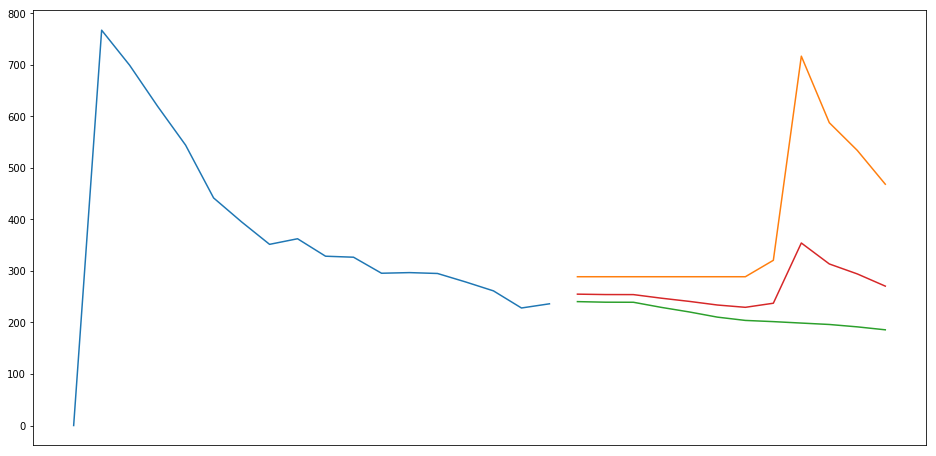

In [39]:
a = 0.3
well = list(npreds.keys())[13]
plt.figure(figsize=(16, 8))
plt.plot(prod[well])
plt.plot(npreds[well])
plt.plot(apreds[well])
plt.plot(a * npreds[well] + (1 - a) * apreds[well])
plt.xticks([])

In [18]:
for well in list(npreds.keys()):
    best_params[well]['a'] = 0.5
    error = 1e20
    for a in np.linspace(0, 1, 10):
        clear_output(wait=True)
        print(well)
        k = prod[well].dropna().size * 2 // 3
        prod_train = prod[well].dropna().drop(tpreds[well].index)
        prod_test = prod[well].loc[tpreds[well].index]
        try:
            arima = ARIMA(prod_train, order=best_params[well]['order'], freq='MS')
            model = arima.fit(trend=best_params[well]['trend'])
            f = pd.Series(model.forecast(prod_test.size)[0], prod_test.index)
            f = a * f + (1 - a) * tpreds[well]
            cur_error = mae(prod_test, f)
            print(cur_error, end=' ')
            if cur_error < error:
                error = cur_error
                best_params[well]['a'] = a
        except:
            continue

2b59cbf6b8e46e09
320.7055152109567 

In [19]:
best_params

{'0089b3f545d8b49c': {'a': 0.0, 'order': (4, 1, 0), 'trend': 'c'},
 '06413e50041826de': {'a': 0.6666666666666666,
  'order': (1, 0, 0),
  'trend': 'c'},
 '0a6c7b090c4b4e56': {'a': 0.7777777777777777,
  'order': (9, 0, 0),
  'trend': 'nc'},
 '0b68e26f46bae74f': {'a': 0.0, 'order': (2, 0, 0), 'trend': 'nc'},
 '1d5ef943084c0700': {'a': 1.0, 'order': (1, 1, 0), 'trend': 'nc'},
 '1e6133531afe2bd9': {'a': 0.8888888888888888,
  'order': (2, 1, 0),
  'trend': 'c'},
 '25c0abad7d8ed2a0': {'a': 1.0, 'order': (2, 1, 0), 'trend': 'nc'},
 '2b59cbf6b8e46e09': {'a': 0.0, 'order': (1, 0, 0), 'trend': 'nc'},
 '2d88d48bccef66d4': {'a': 1.0, 'order': (1, 0, 0), 'trend': 'c'},
 '2f168cbb00dddf74': {'a': 0.6666666666666666,
  'order': (1, 1, 0),
  'trend': 'c'},
 '390ee9791bc03d1b': {'a': 0.0, 'order': (1, 1, 0), 'trend': 'nc'},
 '3b3ed1dcab281038': {'a': 1.0, 'order': (2, 0, 0), 'trend': 'c'},
 '3c4dd52dd0414853': {'a': 0.8888888888888888,
  'order': (1, 0, 0),
  'trend': 'c'},
 '5bbf510fefb48815': {'a': 0

In [20]:
apreds = {}

for well in list(npreds.keys()):
    clear_output(wait=True)
    print(well) 
    arima = ARIMA(prod[well].dropna(), order=best_params[well]['order'], freq='MS')
    model = arima.fit(trend=best_params[well]['trend'])
    apreds[well] = pd.Series(model.forecast(12)[0], index=npreds[well].index)

2b59cbf6b8e46e09


([], <a list of 0 Text xticklabel objects>)

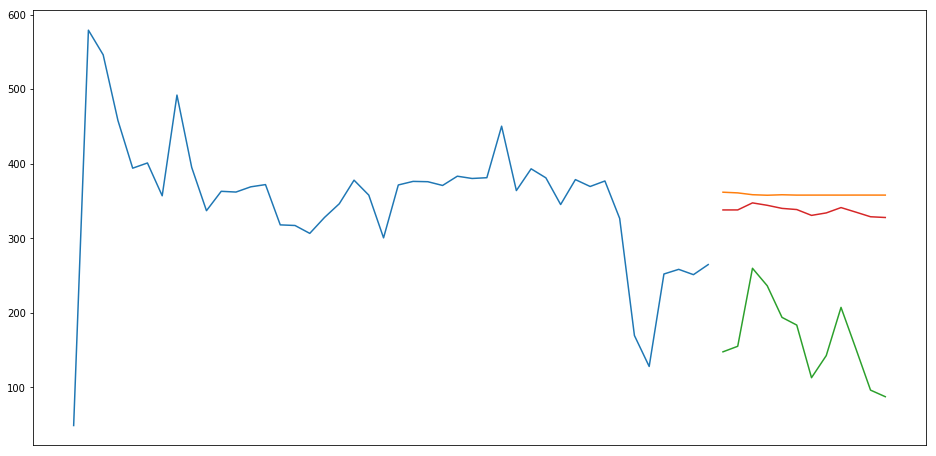

In [43]:
well = list(npreds.keys())[8]
a = best_params[well]['a']
plt.figure(figsize=(16, 8))
plt.plot(prod[well])
plt.plot(npreds[well])
plt.plot(apreds[well])
plt.plot(a * npreds[well] + (1 - a) * apreds[well])
plt.xticks([])

In [34]:
wpreds = {}
for well in npreds.keys():
    wpreds[well] = best_params[well]['a'] * npreds[well] + (1 - best_params[well]['a']) * apreds[well]

In [36]:
p = []
for well in order.well:
    p.append(wpreds[well].values.tolist())

from itertools import chain

p = pd.DataFrame(list(chain(*p)))

p.to_csv('./arima_weighted.csv')

(p > 0).all()

0    True
dtype: bool

In [73]:
def plot_group(group):
    fig = plt.figure(figsize=(20, 20))
    for i, well in enumerate(groups[group]):
        if well in npreds.keys():
            ax = fig.add_subplot(len(groups[group]), 1, i + 1)
            ax.plot(prod[well])
            ax.plot(npreds[well])
            ax.plot(apreds[well])
            a = best_params[well]['a']
            ax.plot(a * npreds[well] + (1 - a) * apreds[well])
            ax.set_xticks([])

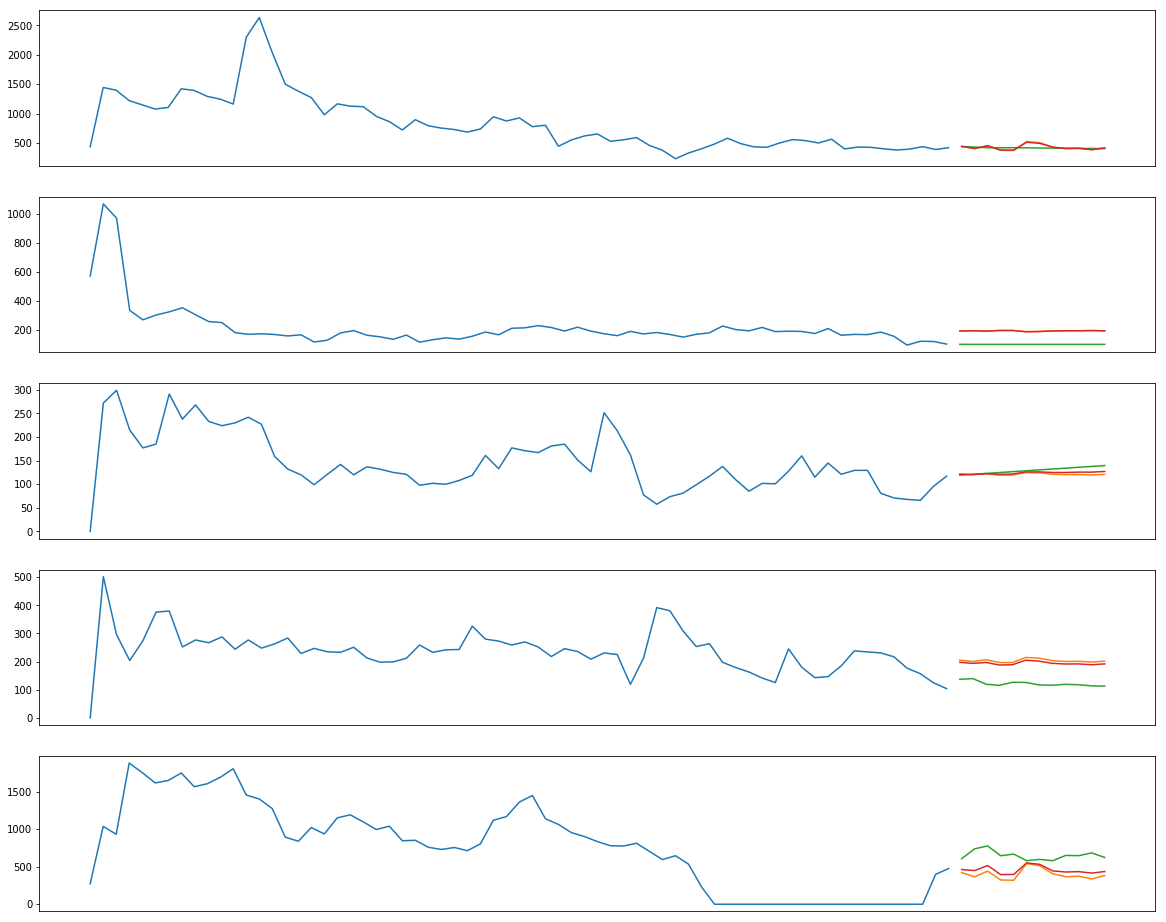

In [77]:
plot_group(43)